## OOI NetCDF Data Access Part 2

You will learn:

* how to read in multiple NetCDF data files directly from the THREDDS directory
* how to work with NetCDF data using Xarray
* how to plot data using Matplotlib
* how to create an interactive plot using Bokeh

### Reading in multiple data files

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import requests
import xarray as xr
import pandas as pd
import os

Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file.

In [2]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180814T230912-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180814T230912-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0003_GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered_20161030T233001-20180109T120001.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180814T230912-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0002_GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered_20151125T193001-20161105T184501.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180814T230912-GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered/deployment0001_GA03FLMA-RIM01-02-CTDMOG040-recovered_inst-ctdmo_ghqr_instrument_recovered_20150317T194501-20151122T120001.nc']

Load all files into a single xarray dataset.

### Exploring the data in Python using Xarray

<b>Tip:</b> To get an overview of what is inside the stream data package, visit http://ooi.visualocean.net/instruments/view/GA03FLMA-RIM01-02-CTDMOG040 and click on the stream link (ctdmo_ghqr_instrument_recovered).

In [3]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                                  (time: 98995)
Coordinates:
    obs                                      (time) int64 dask.array<shape=(98995,), chunksize=(75,)>
  * time                                     (time) datetime64[ns] 2015-03-17T19:45:01 ...
    pressure                                 (time) float64 dask.array<shape=(98995,), chunksize=(75,)>
    lat                                      (time) float64 dask.array<shape=(98995,), chunksize=(75,)>
    lon                                      (time) float64 dask.array<shape=(98995,), chunksize=(75,)>
Data variables:
    deployment                               (time) int32 dask.array<shape=(98995,), chunksize=(75,)>
    id                                       (time) |S64 dask.array<shape=(98995,), chunksize=(75,)>
    conductivity                             (time) float64 dask.array<shape=(98995,), chunksize=(75,)>
    ctd_time                                 (time) datetime64[ns] dask.array<shape

Examine a variable.

In [4]:
ds.ctdmo_seawater_temperature

<xarray.DataArray 'ctdmo_seawater_temperature' (time: 98995)>
dask.array<shape=(98995,), dtype=float64, chunksize=(75,)>
Coordinates:
    obs       (time) int64 dask.array<shape=(98995,), chunksize=(75,)>
  * time      (time) datetime64[ns] 2015-03-17T19:45:01 2015-03-17T20:00:01 ...
    pressure  (time) float64 dask.array<shape=(98995,), chunksize=(75,)>
    lat       (time) float64 dask.array<shape=(98995,), chunksize=(75,)>
    lon       (time) float64 dask.array<shape=(98995,), chunksize=(75,)>
Attributes:
    comment:                  Seawater temperature near the sensor.
    long_name:                Seawater Temperature
    precision:                4
    data_product_identifier:  TEMPWAT_L1
    standard_name:            sea_water_temperature
    units:                    ºC
    ancillary_variables:      temperature
    _ChunkSizes:              10000

Check the sampling frequency.

In [5]:
df = ds.to_dataframe()
res = (pd.Series(df.index[1:]) - pd.Series(df.index[:-1])).value_counts()
res

0 days 00:15:00    98401
0 days 00:00:00      558
0 days 00:14:59       17
0 days 00:15:01       17
3 days 07:30:00        1
Name: time, dtype: int64

Link to [OOI Observation and Sampling Approach](https://oceanobservatories.org/observation-and-sampling-approach/) design document.

### Plotting the data using Matplotlib

In [6]:
import matplotlib.pyplot as plt

Plot a variable with Matplotlib under the hood of Xarray.

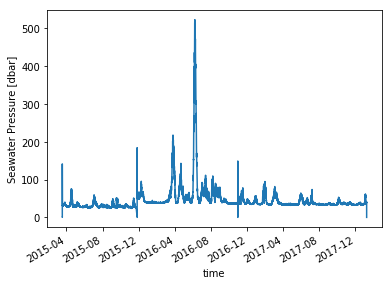

In [7]:
ds.ctdmo_seawater_pressure.plot()

Use matplotlib arguments to make a nicer plot.

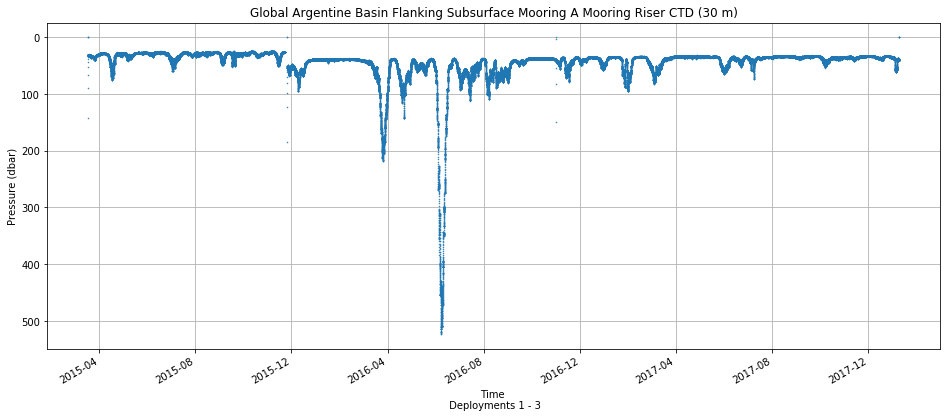

In [8]:
fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds.ctdmo_seawater_pressure.plot(linestyle = 'None', 
                                   marker='.', 
                                   markersize=1,
                                   ax=ax)

ax.invert_yaxis()
ax.grid()

plt.title('Global Argentine Basin Flanking Subsurface Mooring A Mooring Riser CTD (30 m)')
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time \n Deployments 1 - 3')
plt.show()

This CTD is supposed to be stationary at around 30 m depth in the water column, but violent storms in the southern himisphere can draw the CTD mooring chain down by hundreds of meters. More information about the Flanking Subsurface Mooring A can be found [here](http://oceanobservatories.org/site/ga03flma/).

### Creating interactive plots with Bokeh

In [9]:
from bokeh.plotting import figure, output_file, reset_output, show, ColumnDataSource, save
from bokeh.layouts import column
from bokeh.models import BoxAnnotation
from bokeh.io import output_notebook

In [10]:
source = ColumnDataSource(
    data=dict(
        x=list(ds.time.values),
        y=list((ds.ctdmo_seawater_pressure.values*-1))
    )
)

s = figure(width=950,
           height=500,
           title='Global Argentine Basin Flanking Subsurface Mooring A Mooring Riser CTD (30 m)',
           x_axis_label='Time (GMT)',
           y_axis_label='Pressure (dbar)',
           x_axis_type='datetime')

s.line('x', 'y', line_width=3, source=source)
s.circle('x', 'y', fill_color='white', size=4, source=source)

output_notebook()
show(s)

# save the plot as a sharable interactive html file.
output_file(os.getcwd())
save(s, filename='pressure.html')

Loading BokehJS ...

'/home/jovyan/ohw2018_tutorials/day2/ooi_data_access/pressure.html'